<a href="https://colab.research.google.com/github/baricio00/Health-Informatics-2025-26/blob/main/Copy_of_Lab_V_SMHD_25_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<font size="6">Statistical Models for Healthcare Data</font>**

**<font size="5">MSc in Health Informatics - UniSR - A.Y. 2025-2026</font>**

Prof. Lara Cavinato - Dott. Vittorio Torri

---

<font size="4">Lab V - Cross-validation, Feature Selection, Regularization, Generalized Linear Mixed Models</font>

# Libraries

In [2]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import numpy as np

In [5]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
import statsmodels.api as sm

In [7]:
np.random.seed(1234)

In [8]:
import scipy.stats as stats

In [9]:
from tqdm.notebook import tqdm

# Load Dataset

In [10]:
df = pd.read_csv('hf_dataset_lab_iv.csv')

In [11]:
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,bmi,rehospitalizations,ef_cat
0,75.00,0,582,0,20.73,1,265000.00,1.90,138.39,Male,0,4,True,30.82,4,reduced
1,55.00,0,7861,0,29.02,0,263358.03,1.10,131.90,Male,0,6,True,25.40,0,reduced
2,65.00,0,146,0,26.24,0,162000.00,1.30,143.66,Male,1,7,True,29.45,3,reduced
3,50.00,1,111,0,10.21,0,210000.00,1.90,135.03,Male,0,7,True,36.06,2,reduced
4,65.00,1,160,1,19.33,0,327000.00,2.70,136.08,Female,0,8,True,33.69,4,reduced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.00,0,61,1,38.05,1,155000.00,1.10,135.58,Male,1,270,False,25.60,0,reduced
295,55.00,0,1820,0,35.20,0,270000.00,1.20,142.02,Female,0,271,False,29.39,2,reduced
296,45.00,0,2060,1,62.32,0,742000.00,0.80,136.38,Female,0,278,False,20.71,0,preserved
297,45.00,0,2413,0,37.49,0,140000.00,1.40,133.91,Male,1,280,False,27.76,1,reduced


In [12]:
cat_vars = ['anaemia', 'diabetes', 'high_blood_pressure',  'sex',  'smoking',  'DEATH_EVENT']
num_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'bmi', 'time', 'rehospitalizations']

# Cross-validation

## Model

Let's consider again the model for the number of rehospitalizations in 90 days (last model of Lab IV)

$$ Y \sim \text{Poisson}(\lambda) \quad \text{where} \quad \lambda = e^{\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p} $$


every time I need to re-fit the model on new test set

In [13]:
df_encoded = pd.get_dummies(df, columns=cat_vars, drop_first=True, dtype=int)

In [14]:
input_vars = ['age', 'sex_Male', 'bmi', 'ejection_fraction', 'serum_sodium', 'serum_creatinine', 'creatinine_phosphokinase',
              'diabetes_1', 'smoking_1', 'high_blood_pressure_1', 'anaemia_1']


X = df_encoded[input_vars]
y = df_encoded['rehospitalizations']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)

train_index = X_train.index
test_index = X_test.index

X_train_1 = X_train[input_vars]
X_test_1 = X_test[input_vars]

X_train_1 = sm.add_constant(X_train_1)
X_test_1 = sm.add_constant(X_test_1)

poisson_model = sm.GLM(y_train, X_train_1, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     rehospitalizations   No. Observations:                  239
Model:                            GLM   Df Residuals:                      227
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -317.41
Date:                Wed, 17 Dec 2025   Deviance:                       263.97
Time:                        11:12:48   Pearson chi2:                     253.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9341
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = poisson_model.predict(X_test_1)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')

Mean Squared Error: 1.29
Mean Absolute Error: 0.85


## K-fold Cross-Validation

Let's measure the model performance (MSE and MAE) with 10-fold cross-validation

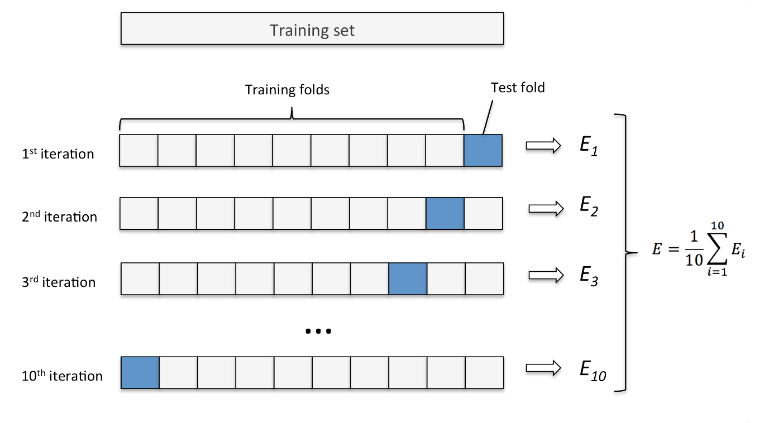

In [16]:
from sklearn.model_selection import KFold

In [17]:
# Initialize KFold with 10 splits
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=1234) #it's better to set shuffle as true, that performs a random shuffle around my points
# sometimes data are ordered, or they depend on other data, so maybe it's possible that are not random or there is some pattern
# so, when possible, it's better to avoid patterns and do the division in folds as random as possible

# Initialize lists to store metrics for each fold
mse_scores = []
mae_scores = []

# Cross-Validation loop
for train_index, test_index in kf.split(X):
  # at each iteration I have different X_train/X_test and different y_train/y_test
    # Select the training and test data for the current iteration
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_1 = sm.add_constant(X_train)
    X_test_1 = sm.add_constant(X_test)

    # Fit the model on the current training folds
    poisson_model = sm.GLM(y_train, X_train_1, family=sm.families.Poisson()).fit()

    # Compute the output on the current test fold
    y_pred = poisson_model.predict(X_test_1)

    # Compute and store MSE and MAE
    mse_scores.append(mean_squared_error(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

# Calculate mean and standard deviation for each metric across all folds
mse_mean, mse_std = np.mean(mse_scores), np.std(mse_scores)
mae_mean, mae_std = np.mean(mae_scores), np.std(mae_scores)

print(f"10-Fold CV Mean Squared Error: Mean={mse_mean:.4f}, Std={mse_std:.4f}")
print(f"10-Fold CV Mean Absolute Error: Mean={mae_mean:.4f}, Std={mae_std:.4f}")
# it's what people want to know from papers

10-Fold CV Mean Squared Error: Mean=4.8187, Std=9.4505
10-Fold CV Mean Absolute Error: Mean=1.0544, Std=0.3999


There are important differences compared to the values on the test set!

## Leave-One-Out (LOO) Cross-Validation

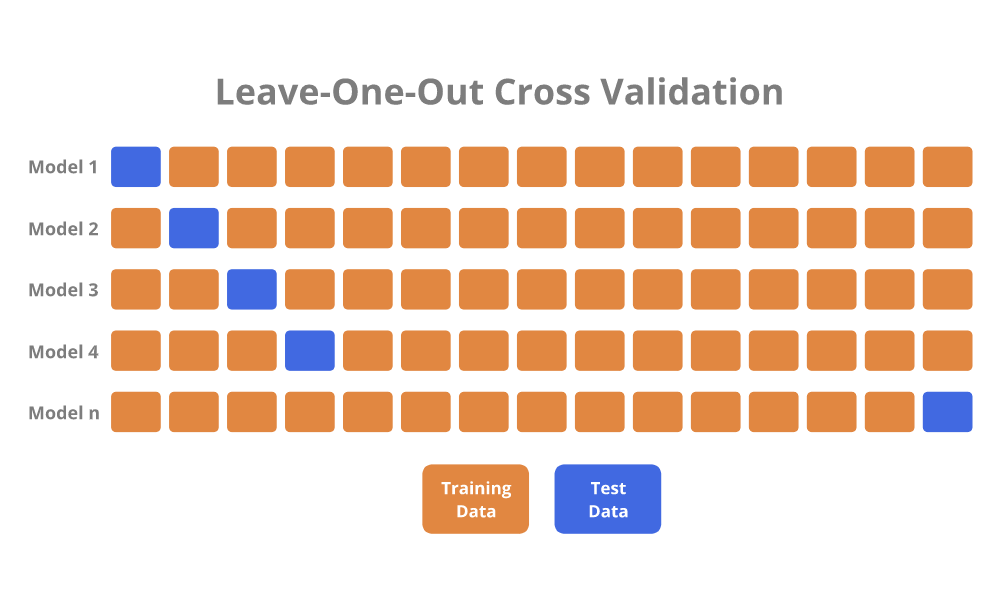

at every iteration, I am using almost all the points. The performance at each fold is not so precise (I am losing ~10% of data at each iteration). The issue are 2
- I have to repeat the model infinite times
- the bias. The variance I will compute at each iteration is very high. It's very precise but very variance makes me not understand the range where the estimate was performed

In [19]:
from tqdm.notebook import tqdm
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

# Initialize lists to store metrics for each LOO iteration
mse_scores = []
mae_scores = []

# Cross-Validation loop
for train_index, test_index in tqdm(loo.split(X), total=len(X)): # tqdm allows to visualize a progress bar
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_1 = sm.add_constant(X_train)
    X_test_1 = sm.add_constant(X_test, has_constant='add') # has_constant = 'add' is needed to make it work with a single point

    # Fit the Poisson regression model
    poisson_model = sm.GLM(y_train, X_train_1, family=sm.families.Poisson()).fit()

    # Prediction on the test fold (single data point)
    y_pred = poisson_model.predict(X_test_1)

    # Calculate and store metrics on test point
    mse_scores.append(mean_squared_error([y_test.iloc[0]], [y_pred]))
    mae_scores.append(mean_absolute_error([y_test.iloc[0]], [y_pred]))

# Calculate mean and standard deviation for each metric across all LOO iterations
mse_mean, mse_std = np.mean(mse_scores), np.std(mse_scores)
mae_mean, mae_std = np.mean(mae_scores), np.std(mae_scores)

print(f"LOO CV Mean Squared Error: Mean={mse_mean:.4f}, Std={mse_std:.4f}")
print(f"LOO CV Mean Absolute Error: Mean={mae_mean:.4f}, Std={mae_std:.4f}")


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

LOO can be very expensive with more complex models / more features

LOO has a high variance but a very low bias

The main reason to prefer it is if you have a very small dataset (and a light model) and so the training set should be as large as possible, and even 90% (as it would be for 10-fold CV) could be too small.

Another situations where LOO can be preferred are instance-based models like K-Nearest Neighbours (not part of the program of our course)

# Feature Selection

Best subset selection: $\mathcal{O}(2^p)$ --> often intractable

Forward and Backward selection: $\mathcal{O}(p^2)$ --> typically doable


## Linear Regression for ejection fraction

NB: The following cell takes about 5 minutes to run!

In [ ]:
import time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import ExhaustiveFeatureSelector

# Prepare data
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time', 'rehospitalizations',
        'DEATH_EVENT']]
y = df['ejection_fraction']

numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
categorical_vars = cat_vars.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Preprocessing
# it's better to have a standardization of the variables
# it allows to specify a different preprocessing of different type of variables
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars), # to fit it on the training set
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()
n = len(y_test)

# Helper function for metrics computation
def get_model_stats(y_true, y_pred, p, mse_full):
    n = len(y_true)
    rss = np.sum((y_true - y_pred) ** 2)
    mse = rss / n
    r2 = 1 - (rss / np.sum((y_true - np.mean(y_true)) ** 2))
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
    aic = n * np.log(mse) + 2 * p
    bic = n * np.log(mse) + p * np.log(n)
    cp = rss / mse_full - n + 2 * p
    return aic, bic, cp, adj_r2


# Full model (OLS)
start = time.time()
ols_model = LinearRegression().fit(X_train_proc, y_train)
train_rss_full = np.sum((y_train - ols_model.predict(X_train_proc)) ** 2)
mse_full = train_rss_full / len(y_train)
y_pred_ols = ols_model.predict(X_test_proc)
aic_ols, bic_ols, cp_ols, adj_r2_ols = get_model_stats(y_test, y_pred_ols, X_test_proc.shape[1] + 1, mse_full)
time_ols = time.time() - start

print('OLS completed!')

# Best Subset Selection
start = time.time()
efs = ExhaustiveFeatureSelector(LinearRegression(), min_features=1, max_features=10, scoring='r2', cv=5)
# "scoring": what is the metric you have to use?
# "cv": cross-validation, it tells what you will do at each iteration, you will run 5-10 folds and compute the min value of the validation.
# It says how many times to fit the model at each iteration, so increasing it will increase the computational effort
efs.fit(X_train_proc, y_train)
best_subset_idx = list(efs.best_idx_)
model_best = LinearRegression().fit(X_train_proc[:, best_subset_idx], y_train)
y_pred_best = model_best.predict(X_test_proc[:, best_subset_idx])
aic_best, bic_best, cp_best, adj_r2_best = get_model_stats(y_test, y_pred_best, len(best_subset_idx) + 1, mse_full)
time_best = time.time() - start

print('Best subset completed!')

# Forward Selection
# one feature at a time and I see which feture is the best. Is there another one that is the best? I iterate one more time and measure the
# performance of another feature and I see if there's any improvement. This not guarantees the best feature: the true best subset of
# features does not include the measured features in this way, but it's still possible to find a good subset
start = time.time()
sfs_forward = SequentialFeatureSelector(LinearRegression(), direction='forward', cv=5, scoring='r2')
sfs_forward.fit(X_train_proc, y_train)
fwd_idx = sfs_forward.get_support()
model_fwd = LinearRegression().fit(X_train_proc[:, fwd_idx], y_train)
y_pred_fwd = model_fwd.predict(X_test_proc[:, fwd_idx])
aic_fwd, bic_fwd, cp_fwd, adj_r2_fwd = get_model_stats(y_test, y_pred_fwd, sum(fwd_idx) + 1, mse_full)
time_fwd = time.time() - start

print('Forward completed!')

# Backward Selection
# start with all the features and progresively eliminate one by one. It has one issue: if I have many features I cannot even start it.
# I can start with a small subset, but it's better to go with the forward
start = time.time()
sfs_backward = SequentialFeatureSelector(LinearRegression(), direction='backward', cv=5, scoring='r2')
sfs_backward.fit(X_train_proc, y_train)
bwd_idx = sfs_backward.get_support()
model_bwd = LinearRegression().fit(X_train_proc[:, bwd_idx], y_train)
y_pred_bwd = model_bwd.predict(X_test_proc[:, bwd_idx])
aic_bwd, bic_bwd, cp_bwd, adj_r2_bwd = get_model_stats(y_test, y_pred_bwd, sum(bwd_idx) + 1, mse_full)
time_bwd = time.time() - start

print('Backward completed!')

# Compile metrics
metrics_df = pd.DataFrame([
    {'Model': 'OLS (All)', 'AIC': aic_ols, 'BIC': bic_ols, "Cp": cp_ols, 'Adj. R^2': adj_r2_ols, 'Time (s)': time_ols},
    {'Model': 'Best Subset', 'AIC': aic_best, 'BIC': bic_best, "Cp": cp_best, 'Adj. R^2': adj_r2_best, 'Time (s)': time_best},
    {'Model': 'Forward Selection', 'AIC': aic_fwd, 'BIC': bic_fwd, "Cp": cp_fwd, 'Adj. R^2': adj_r2_fwd, 'Time (s)': time_fwd},
    {'Model': 'Backward Selection', 'AIC': aic_bwd, 'BIC': bic_bwd, "Cp": cp_bwd, 'Adj. R^2': adj_r2_bwd, 'Time (s)': time_bwd}
])



# Summary results
print("\n\nModel Comparison (AIC, BIC, Cp, Time):")
print(metrics_df)

print("\nSelected Features:")
print('Best subset:\n')
print(feature_names[best_subset_idx])
print('\nForward selection:\n')
print(feature_names[fwd_idx])
print('\nBackward selection:\n')
print(feature_names[bwd_idx])

 # sometimes the features that are selected one by one, I can choose an intersection, or just select one selected by the forward and one by the backward.


ModuleNotFoundError: No module named 'mlxtend'

The forward and backward are adding something useless, but it's an expected outcome

In [ ]:
print(f'OLS Time: {time_ols:.2f} sec')
print(f'Best subset Time: {time_best:.2f} sec')
print(f'Forward selection Time: {time_fwd:.2f} sec')
print(f'Backward selection Time: {time_bwd:.2f} sec')

OLS Time: 0.03 sec
Best subset Time: 277.59 sec
Forward selection Time: 2.86 sec
Backward selection Time: 2.94 sec


## Logistic Regression for Death

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time',
        'ejection_fraction','rehospitalizations'
        ]]
y = df['DEATH_EVENT']

numeric_vars = num_vars.copy()
categorical_vars = cat_vars.copy()
categorical_vars.remove('DEATH_EVENT')  # remove target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()
n = len(y_test)

# Fit full logistic model
start = time.time()
logreg_full = LogisticRegression().fit(X_train_proc, y_train)
y_pred_full = logreg_full.predict(X_test_proc)
y_proba_full = logreg_full.predict_proba(X_test_proc)[:, 1]
logloss_full = log_loss(y_test, y_proba_full)
time_full = time.time() - start

def get_classification_metrics(y_true, y_prob, p, logloss_full):
    n = len(y_true)
    log_loss_model = log_loss(y_true, y_prob)
    ll = -log_loss(y_true, y_prob, normalize=False)
    aic = 2 * p - 2 * ll
    bic = p * np.log(n) - 2 * ll
    cp = (n * log_loss_model) / logloss_full - n + 2 * p
    return aic, bic, cp


logloss_full = log_loss(y_test, y_proba_full)
aic_full, bic_full, cp_full = get_classification_metrics(y_test, y_proba_full, X_train_proc.shape[1] + 1, logloss_full)


# Best Subset Selection
start = time.time()
efs = ExhaustiveFeatureSelector(LogisticRegression(), min_features=1, max_features=10,
                                scoring='accuracy', cv=5, n_jobs=-1)
efs.fit(X_train_proc, y_train)
best_subset_idx = list(efs.best_idx_)
model_best = LogisticRegression().fit(X_train_proc[:, best_subset_idx], y_train)
y_pred_best = model_best.predict(X_test_proc[:, best_subset_idx])
y_proba_best = model_best.predict_proba(X_test_proc[:, best_subset_idx])[:, 1]
time_best = time.time() - start
aic_best, bic_best, cp_best = get_classification_metrics(y_test, y_proba_best, len(best_subset_idx) + 1, logloss_full)


# Forward Selection
start = time.time()
sfs_forward = SequentialFeatureSelector(LogisticRegression(), direction='forward', scoring='accuracy', cv=5, n_jobs=-1)
sfs_forward.fit(X_train_proc, y_train)
fwd_index = sfs_forward.get_support()
model_fwd = LogisticRegression().fit(X_train_proc[:, fwd_index], y_train)
y_proba_fwd = model_fwd.predict_proba(X_test_proc[:, fwd_index])[:, 1]
time_fwd = time.time() - start
aic_fwd, bic_fwd, cp_fwd = get_classification_metrics(y_test, y_proba_fwd, sum(fwd_index) + 1, logloss_full)


# Backward Selection
start = time.time()
sfs_backward = SequentialFeatureSelector(LogisticRegression(), direction='backward', scoring='accuracy', cv=5, n_jobs=-1)
sfs_backward.fit(X_train_proc, y_train)
bwd_index = sfs_backward.get_support()
model_bwd = LogisticRegression().fit(X_train_proc[:, bwd_index], y_train)
y_proba_bwd = model_bwd.predict_proba(X_test_proc[:, bwd_index])[:, 1]
time_bwd = time.time() - start
aic_bwd, bic_bwd, cp_bwd = get_classification_metrics(y_test, y_proba_bwd, sum(bwd_index) + 1, logloss_full)

# Summary table
metrics_df = pd.DataFrame([
    {'Model': 'Full Logistic', 'AIC': aic_full, 'BIC': bic_full, 'Cp': cp_full, 'Time (s)': time_full},
    {'Model': 'Best Subset', 'AIC': aic_best, 'BIC': bic_best, 'Cp': cp_best, 'Time (s)': time_best},
    {'Model': 'Forward Selection', 'AIC': aic_fwd, 'BIC': bic_fwd, 'Cp': cp_fwd, 'Time (s)': time_fwd},
    {'Model': 'Backward Selection', 'AIC': aic_bwd, 'BIC': bic_bwd, 'Cp': cp_bwd, 'Time (s)': time_bwd}
])

# Selected features
features_df = pd.concat([
    pd.DataFrame({'Feature': feature_names[best_subset_idx], 'Method': 'Best Subset'}),
    pd.DataFrame({'Feature': feature_names[fwd_index], 'Method': 'Forward Selection'}),
    pd.DataFrame({'Feature': feature_names[bwd_index], 'Method': 'Backward Selection'})
])

# Output results
print("Logistic Regression Model Comparison:")
print(metrics_df)

print("\nSelected Features per Method:")
print(features_df)


Features: 15913/15913

Logistic Regression Model Comparison:
                Model   AIC    BIC    Cp  Time (s)
0       Full Logistic 79.65 111.06 30.00      0.18
1         Best Subset 66.25  74.63 18.40    415.78
2   Forward Selection 75.44  92.20 27.84      6.07
3  Backward Selection 71.89  88.64 23.55      6.05

Selected Features per Method:
                      Feature              Method
0                   num__time         Best Subset
1     num__rehospitalizations         Best Subset
2  cat__high_blood_pressure_1         Best Subset
0              num__platelets   Forward Selection
1                   num__time   Forward Selection
2     num__rehospitalizations   Forward Selection
3              cat__anaemia_1   Forward Selection
4  cat__high_blood_pressure_1   Forward Selection
5               cat__sex_Male   Forward Selection
6              cat__smoking_1   Forward Selection
0       num__serum_creatinine  Backward Selection
1                   num__time  Backward Selection
2     num__rehospitalizati

In [ ]:
print(f'OLS Time: {time_ols:.2f} sec')
print(f'Best subset Time: {time_best:.2f} sec')
print(f'Forward selection Time: {time_fwd:.2f} sec')
print(f'Backward selection Time: {time_bwd:.2f} sec')

OLS Time: 0.03 sec
Best subset Time: 415.78 sec
Forward selection Time: 6.07 sec
Backward selection Time: 6.05 sec


# Regularized Linear Regression

Ridge Regression:

$$
\hat{\beta} = \underset{\beta}{\arg \min} \left( \sum_{i=1}^n (y_i - X_i \beta)^2 + \alpha \sum_{j=1}^p \beta_j^2 \right)
$$

Lasso Regression:
$$
\hat{\beta} = \underset{\beta}{\arg \min} \left( \sum_{i=1}^n (y_i - X_i \beta)^2 + \alpha \sum_{j=1}^p |\beta_j| \right)
$$

Elastic Net Regression:
$$
\hat{\beta} = \underset{\beta}{\arg \min} \left( \sum_{i=1}^n (y_i - X_i \beta)^2 + \alpha \left( (1 - \lambda) \sum_{j=1}^p \beta_j^2 + \lambda \sum_{j=1}^p |\beta_j| \right) \right)
$$


Elastic Net is a combination of ridge and lasso, which is the one implemented in statsmodels. The weights $\alpha$ and $\lambda$ (L1\_wt) allows to control the amount of the two regularizations, possibly leading to ridge regression (L1_wt = 0) and lasso (L1_wt = 1).

Statsmodels does not have a direct implementation of ridge and lasso (differently from scikit-learn) but they can be obtained by elastic net. Unfortunately, regularized models do not currently have the same summary method of OLS in statsmodels.

Regularized linear regression **requires to standardize numerical features.** It's useful in many cases where n features are in different scales. If im using ridge or lasso, I must standardize numerical features




If I have different performance on the test_set, this is an overfitting situation.

## Ridge VS OLS

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate

# Define X and y
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time', 'rehospitalizations',
        'DEATH_EVENT']]
y = df['ejection_fraction']

numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
categorical_vars = cat_vars.copy()

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

# Pipelines
# object provided by scikit learn that put together things (models, ecc.) into this pipeline
# and I can create a pipeline where I have the same preprocessor, different model, different parameters, ecc.
ols_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1e2))  # To be tuned
])

# Fit models (for coefficient comparison)
ols_pipeline.fit(X, y)
ridge_pipeline.fit(X, y)

# Feature names
feature_names = ridge_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Coefficients
ols_coefs = ols_pipeline.named_steps['regressor'].coef_
ridge_coefs = ridge_pipeline.named_steps['regressor'].coef_

# Intercepts
ols_intercept = ols_pipeline.named_steps['regressor'].intercept_
ridge_intercept = ridge_pipeline.named_steps['regressor'].intercept_

# Combine coefficients
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names),
    'OLS': [ols_intercept] + list(ols_coefs),
    'Ridge': [ridge_intercept] + list(ridge_coefs)
})

print("Coefficient Comparison:")
print(coef_df)

# I will obtain the parameters (beta0 for both the OLS and the Ridge)

Coefficient Comparison:
                          Feature    OLS  Ridge
0                       Intercept  39.06  38.93
1                        num__age   0.93   0.91
2   num__creatinine_phosphokinase  -0.15  -0.42
3                  num__platelets   0.25   0.26
4           num__serum_creatinine   9.96   4.01
5               num__serum_sodium  -0.96  -1.06
6                        num__bmi -11.45  -6.13
7                       num__time  -0.80  -0.29
8         num__rehospitalizations  -3.73  -2.05
9                  cat__anaemia_1   0.35   0.21
10                cat__diabetes_1   0.17  -0.12
11     cat__high_blood_pressure_1  -0.33   0.02
12                  cat__sex_Male  -1.02  -0.80
13                 cat__smoking_1   0.81  -0.12
14          cat__DEATH_EVENT_True  -2.25  -1.20


Quick cross-validation with scikit-learn pipelines:

In [ ]:
# Scoring metrics
scoring = {
    'r2': 'r2',
    'neg_mse': 'neg_mean_squared_error', # neg because metriscs are maximized by cross_validate, this is -MSE
    'neg_mae': 'neg_mean_absolute_error' # and this is -MAE
}

# Perform CV
cv_results_ols = cross_validate(ols_pipeline, X, y, cv=5, scoring=scoring)
cv_results_ridge = cross_validate(ridge_pipeline, X, y, cv=5, scoring=scoring)

In [ ]:
cv_results_ols

{'fit_time': array([0.02055812, 0.01729584, 0.01605225, 0.01524472, 0.01489162]),
 'score_time': array([0.01600575, 0.01334119, 0.0103035 , 0.00954056, 0.0112381 ]),
 'test_r2': array([ 0.41076976,  0.60533656,  0.58620448,  0.70352385, -0.03960346]),
 'test_neg_mse': array([-95.21595328, -73.632566  , -65.48273873, -47.12733243,
        -70.30183995]),
 'test_neg_mae': array([-7.20230855, -6.68680118, -6.53494523, -5.38130639, -7.24983128])}

In [ ]:
def summarize_cv(cv_results, model_name, X):
    r2_vals  = cv_results['test_r2']
    mse_vals = -cv_results['test_neg_mse']
    mae_vals = -cv_results['test_neg_mae']

    n, p = X.shape

    adj_r2_vals = [
      1 - (1 - r2_vals[i]) * (n*0.9 - 1) / (n*0.9 - p - 1)
      for i in range(len(r2_vals))
    ]

    # Means
    r2_mean  = np.mean(r2_vals)
    adj_r2_mean = np.mean(adj_r2_vals)
    mse_mean = np.mean(mse_vals)
    mae_mean = np.mean(mae_vals)

    # Std
    r2_std  = np.std(r2_vals,  ddof=1)
    adj_r2_std = np.std(adj_r2_vals, ddof=1)
    mse_std = np.std(mse_vals, ddof=1)
    mae_std = np.std(mae_vals, ddof=1)

    return {
        'Model': model_name,
        'Adj R^2': adj_r2_mean,
        'Adj R^2 std': adj_r2_std,
        'MSE mean': mse_mean,
        'MSE std': mse_std,
        'MAE mean': mae_mean,
        'MAE std': mae_std,
    }

metrics_cv_df = pd.DataFrame([
    summarize_cv(cv_results_ols, 'OLS', X),
    summarize_cv(cv_results_ridge, 'Ridge', X)
])

print("\nCross-Validation Performance Metrics:")
print(metrics_cv_df)


Cross-Validation Performance Metrics:
   Model  Adj R^2  Adj R^2 std  MSE mean  MSE std  MAE mean  MAE std
0    OLS     0.42         0.31     70.35    17.26      6.61     0.76
1  Ridge     0.23         0.28    105.45    52.05      7.55     1.21


## Lasso

In [ ]:
from sklearn.linear_model import Lasso

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=1.0))  # To be tuned
])

lasso_pipeline.fit(X, y)

feature_names = ridge_pipeline.named_steps['preprocessor'].get_feature_names_out()

lasso_coefs = lasso_pipeline.named_steps['regressor'].coef_

lasso_intercept = lasso_pipeline.named_steps['regressor'].intercept_

# Combine coefficients
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names),
    'Lasso coeff': [lasso_intercept] + list(lasso_coefs)
})

# Scoring metrics
scoring = {
    'r2': 'r2',
    'neg_mse': 'neg_mean_squared_error',
    'neg_mae': 'neg_mean_absolute_error'
}

# Perform CV
cv_results_lasso = cross_validate(lasso_pipeline, X, y, cv=5, scoring=scoring)

# Compile metrics
cv_df = pd.DataFrame(summarize_cv(cv_results_lasso, 'Lasso', X), index=[0])

print("Coefficient Comparison:")
print(coef_df)

print("\nCross-Validation Mean Performance Metrics:")
print(cv_df)

Coefficient Comparison:
                          Feature  Lasso coeff
0                       Intercept        38.03
1                        num__age         0.00
2   num__creatinine_phosphokinase        -0.00
3                  num__platelets         0.00
4           num__serum_creatinine         6.19
5               num__serum_sodium        -0.09
6                        num__bmi        -9.08
7                       num__time        -0.00
8         num__rehospitalizations        -1.49
9                  cat__anaemia_1         0.00
10                cat__diabetes_1         0.00
11     cat__high_blood_pressure_1        -0.00
12                  cat__sex_Male        -0.00
13                 cat__smoking_1        -0.00
14          cat__DEATH_EVENT_True        -0.00

Cross-Validation Mean Performance Metrics:
   Model  Adj R^2  Adj R^2 std  MSE mean  MSE std  MAE mean  MAE std
0  Lasso     0.41         0.21     76.48    19.14      6.87     0.63


plenty of features are deleted by LASSO, so we can keep the ones that have a higher coefficient than 0

Lasso is often faster, can work with p > n, and shrink coefficients in addition to variable selection

But it does not have the flexibility of the previous methods for feature selection and you have an hyperparameter to tune

## Statsmodels

How can we implement Ridge, Lasso or ElasticNet with statsmodels?

Elastic Net Regression:
$$
\hat{\beta} = \underset{\beta}{\arg \min} \left( \sum_{i=1}^n (y_i - X_i \beta)^2 + \alpha \left( (1 - \lambda) \sum_{j=1}^p \beta_j^2 + \lambda \sum_{j=1}^p |\beta_j| \right) \right)
$$


In [ ]:
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time', 'DEATH_EVENT', 'rehospitalizations']]
y = df['ejection_fraction']

In [ ]:
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def preprocess_data(X, numeric_features, categorical_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ]
    )
    X_transformed = preprocessor.fit_transform(X)
    feature_names = preprocessor.get_feature_names_out()
    return X_transformed, feature_names

def fit_elastic_net(X, y, alpha=1.0, L1_wt=0.5):
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit_regularized(alpha=alpha, L1_wt=L1_wt) # L1_wt is the lambda in the equations above
    return model

# Summarize model results
def summarize_elastic_net(model, X, y, feature_names):
    y_pred = model.predict(sm.add_constant(X))

    r2 = r2_score(y, y_pred)
    n = len(y)
    p = X.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    metrics = {
        'r2': r2,
        'Adj R^2': adj_r2,
        'MSE': mean_squared_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred)
    }

    coef = model.params
    summary_df = pd.DataFrame({'Feature': ['Intercept'] + list(feature_names), 'Coefficient': coef})

    metrics_df = pd.DataFrame(metrics.items(), columns=['Metric', 'Value'])

    return summary_df, metrics_df

Statsmodels's summary for regularized models is not as rich as the one that is directly available for standard (generalized) linear models.

Indeed, there is no closed-form inference for std, p-values, ... on regularized models. There are ways to estimate them (e.g., bootstrapping), but they are not directly provided by statsmodels.

In [ ]:
numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
X_transformed, feature_names = preprocess_data(X, numeric_vars, cat_vars)
elastic_net_model = fit_elastic_net(X_transformed, y, alpha=1.0, L1_wt=1.0)

coef_summary, metrics_summary = summarize_elastic_net(elastic_net_model, X_transformed, y, feature_names)

print("Coefficient Summary:")
print(coef_summary)

print("\nModel Metrics Summary:")
print(metrics_summary)

Coefficient Summary:
                             Feature  Coefficient
const                      Intercept        37.03
x1                          num__age         0.00
x2     num__creatinine_phosphokinase         0.00
x3                    num__platelets         0.00
x4             num__serum_creatinine         6.19
x5                 num__serum_sodium        -0.09
x6                          num__bmi        -9.08
x7                         num__time         0.00
x8           num__rehospitalizations        -1.49
x9                    cat__anaemia_1         0.00
x10                  cat__diabetes_1         0.00
x11       cat__high_blood_pressure_1         0.00
x12                    cat__sex_Male         0.00
x13                   cat__smoking_1         0.00
x14            cat__DEATH_EVENT_True         0.00

Model Metrics Summary:
    Metric  Value
0       r2   0.54
1  Adj R^2   0.52
2      MSE  67.95
3      MAE   6.53


## CV for the regularization coefficient

How to **select** the value of the regularization coefficient?

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Data and features
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time', 'rehospitalizations',
        'DEATH_EVENT']]
y = df['ejection_fraction']

# Feature groups
numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
categorical_vars = cat_vars.copy()

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

# Pipelines
ols_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])


# Hyperparameter grid (alpha)
alphas = np.logspace(-5, 3, 50) # from 10^(-5) to 10^3 with 50 steps
# I experiment with these point and pick the best one
# Typically the range of values of alpha that I want to consider is at the power of 10
ridge_params = {'regressor__alpha': alphas} # specify the parameters for the ridge, sayng that the regressor has a hyperparameter alpha that I want to consider the values from here
lasso_params = {'regressor__alpha': alphas}

# GridSearchCV tuned by MSE (use negative MSE since sklearn maximizes the score)
ridge_cv = GridSearchCV(
    ridge_pipeline, ridge_params, cv=5, # I give the dictionary ridge_params and tell how many fold to perform
    scoring='neg_mean_squared_error', refit=True # at the end I am left with the model with the best value of alpha
)
lasso_cv = GridSearchCV(
    lasso_pipeline, lasso_params, cv=5,
    scoring='neg_mean_squared_error', refit=True # Setting refit = true tells me that the ridge CV and lasso CV will contain already the best model
)

# TO-DO: LOOK FOR NESTED CROSS VALIDATION

# Fit models
ols_pipeline.fit(X_train, y_train)
ridge_cv.fit(X_train, y_train)
lasso_cv.fit(X_train, y_train)

# Best alphas by MSE
print("Best alpha for Ridge (by CV MSE):", ridge_cv.best_params_['regressor__alpha'])
print("Best alpha for Lasso (by CV MSE):", lasso_cv.best_params_['regressor__alpha'])

# Predictions
y_pred_ols = ols_pipeline.predict(X_test)
y_pred_ridge = ridge_cv.predict(X_test)
y_pred_lasso = lasso_cv.predict(X_test)

# Evaluation function
def evaluate(y_true, y_pred, model_name, p):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return {
        'Model': model_name,
        'Adj R^2': adj_r2,
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

# Metrics comparison
metrics_df = pd.DataFrame([
    evaluate(y_test, y_pred_ols, 'OLS', X_test.shape[1]),
    evaluate(y_test, y_pred_ridge, 'Ridge', X_test.shape[1]),
    evaluate(y_test, y_pred_lasso, 'Lasso', X_test.shape[1])
])

print("\nModel Performance Comparison:")
print(metrics_df)

# Coefficient comparison
feature_names = preprocessor.get_feature_names_out()
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names),
    'OLS': [ols_pipeline.named_steps['regressor'].intercept_] + list(ols_pipeline.named_steps['regressor'].coef_),
    'Ridge': [ridge_cv.best_estimator_.named_steps['regressor'].intercept_] + list(ridge_cv.best_estimator_.named_steps['regressor'].coef_),
    'Lasso': [lasso_cv.best_estimator_.named_steps['regressor'].intercept_] + list(lasso_cv.best_estimator_.named_steps['regressor'].coef_)
})

print("\nCoefficient Comparison:")
print(coef_df)

Best alpha for Ridge (by CV MSE): 1e-05
Best alpha for Lasso (by CV MSE): 0.5428675439323859

Model Performance Comparison:
   Model  Adj R^2   MSE  MAE
0    OLS     0.43 58.09 6.38
1  Ridge     0.43 58.09 6.38
2  Lasso     0.41 60.20 6.43

Coefficient Comparison:
                          Feature    OLS  Ridge  Lasso
0                       Intercept  39.13  39.13  38.17
1                        num__age   0.72   0.72   0.00
2   num__creatinine_phosphokinase  -0.37  -0.37  -0.13
3                  num__platelets   0.39   0.39   0.00
4           num__serum_creatinine  10.15  10.15   7.97
5               num__serum_sodium  -0.93  -0.93  -0.43
6                        num__bmi -11.71 -11.71 -10.66
7                       num__time  -0.67  -0.67  -0.00
8         num__rehospitalizations  -3.83  -3.83  -2.33
9                  cat__anaemia_1   0.26   0.26   0.00
10                cat__diabetes_1   0.14   0.14  -0.00
11     cat__high_blood_pressure_1  -0.52  -0.52  -0.00
12                  

A small value for "Best alpha for Ridge (by CV MSE)" tells me to experiment with a lower interval.

Let's plot the CV MSE vs alpha for both ridge and lasso

Exception ignored in: <function tqdm.__del__ at 0x00000181B097A7A0>
Traceback (most recent call last):
  File "c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


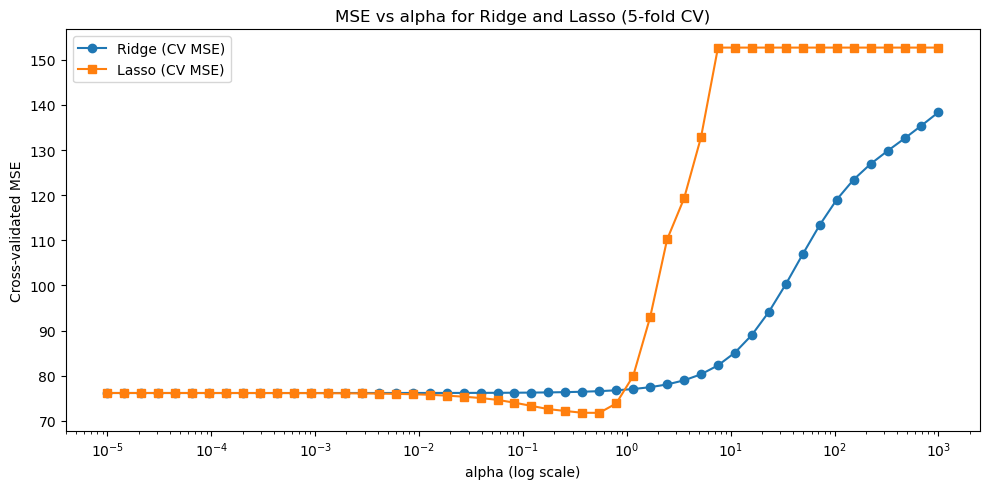

In [ ]:
ridge_alphas = ridge_cv.cv_results_['param_regressor__alpha'].data
ridge_mse_mean = -ridge_cv.cv_results_['mean_test_score']
ridge_mse_std  = ridge_cv.cv_results_['std_test_score']

lasso_alphas = lasso_cv.cv_results_['param_regressor__alpha'].data
lasso_mse_mean = -lasso_cv.cv_results_['mean_test_score']
lasso_mse_std  = lasso_cv.cv_results_['std_test_score']

plt.figure(figsize=(10,5))
plt.plot(ridge_alphas, ridge_mse_mean, marker='o', label='Ridge (CV MSE)')
plt.plot(lasso_alphas, lasso_mse_mean, marker='s', label='Lasso (CV MSE)')

plt.xscale('log')
plt.xlabel('alpha (log scale)')
plt.ylabel('Cross-validated MSE')
plt.title('MSE vs alpha for Ridge and Lasso (5-fold CV)')
plt.legend()
plt.tight_layout()
plt.show()

the mse remains low at a certain point, and then explodes. Means that there is a best value that gives better performance. The ridge doesn't seem to be useful at all

# Regularized Logistic Regression

Logistic Regression can similarly be regularized with ridge or lasso penalty

$$
\min_{\boldsymbol{\beta}}
\left\{
 - \sum_{i=1}^{n}
 \big[
   y_i \log p_i + (1 - y_i)\log(1 - p_i)
 \big]
 \;+\;
 \alpha \sum_{j=1}^{p} \beta_j^{2}
\right\},
\qquad
p_i = \frac{1}{1 + e^{-(\beta_0 + \mathbf{x}_i^\top \boldsymbol{\beta})}}.
$$

penalty term $\alpha \sum_{j=1}^{p} \beta_j^{2}$

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Features and target
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time', 'ejection_fraction', 'rehospitalizations']]
y = df['DEATH_EVENT']

categorical_vars = cat_vars.copy()
categorical_vars.remove('DEATH_EVENT')

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

# Logistic Regression without regularization (penalty='none')
logreg_none_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty=None, max_iter=1000))
])


# Logistic Regression (L2)
logreg_l2_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)) # here I'm introducing a ridge or lasso penalty
])
logreg_l2_params = {'classifier__C': np.logspace(-3, 3, 50)} # regularization coefficient C = 1/alpha. [1e-3, 1e3]
logreg_l2_cv = GridSearchCV(logreg_l2_pipeline, logreg_l2_params, cv=5, scoring='roc_auc') # to find the best value for z parameters

# Logistic Regression (L1)
logreg_l1_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000))
])
logreg_l1_params = {'classifier__C': np.logspace(-3, 3, 50)} # regularization coefficient
logreg_l1_cv = GridSearchCV(logreg_l1_pipeline, logreg_l1_params, cv=5, scoring='roc_auc')

# Fit models
logreg_l2_cv.fit(X_train, y_train)
logreg_l1_cv.fit(X_train, y_train)
logreg_none_pipeline.fit(X_train, y_train)

print("Best C for Logistic Regression (L2):", logreg_l2_cv.best_params_['classifier__C'])
print("Best C for Logistic Regression (L1):", logreg_l1_cv.best_params_['classifier__C'])

# Predictions
y_pred_none = logreg_none_pipeline.predict(X_test)
y_proba_none = logreg_none_pipeline.predict_proba(X_test)[:, 1]

y_pred_l2 = logreg_l2_cv.predict(X_test)
y_proba_l2 = logreg_l2_cv.predict_proba(X_test)[:, 1]

y_pred_l1 = logreg_l1_cv.predict(X_test)
y_proba_l1 = logreg_l1_cv.predict_proba(X_test)[:, 1]

# Evaluation function
def evaluate_classification(y_true, y_pred, y_proba, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba)
    }

# Compare metrics
metrics_classif_df = pd.DataFrame([
    evaluate_classification(y_test, y_pred_none, y_proba_none, 'LogReg None'),
    evaluate_classification(y_test, y_pred_l2, y_proba_l2, 'LogReg L2'),
    evaluate_classification(y_test, y_pred_l1, y_proba_l1, 'LogReg L1')
])

print("\nClassification Performance:")
print(metrics_classif_df)

# Coefficient Comparison
feature_names = logreg_l2_cv.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names),
    'No Reg': [logreg_none_pipeline.named_steps['classifier'].intercept_[0]] +
            list(logreg_none_pipeline.named_steps['classifier'].coef_[0]),
    'L2': [logreg_l2_cv.best_estimator_.named_steps['classifier'].intercept_[0]] +
          list(logreg_l2_cv.best_estimator_.named_steps['classifier'].coef_[0]),
    'L1': [logreg_l1_cv.best_estimator_.named_steps['classifier'].intercept_[0]] +
          list(logreg_l1_cv.best_estimator_.named_steps['classifier'].coef_[0])
})

print("\nCoefficient Comparison:")
print(coef_df)

Best C for Logistic Regression (L2): 0.1206792640639329
Best C for Logistic Regression (L1): 0.1206792640639329

Classification Performance:
         Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  LogReg None      0.85       0.83    0.80      0.82     0.90
1    LogReg L2      0.85       0.86    0.76      0.81     0.91
2    LogReg L1      0.82       0.82    0.72      0.77     0.90

Coefficient Comparison:
                          Feature  No Reg    L2    L1
0                       Intercept   -0.93 -0.58 -0.92
1                        num__age    0.55  0.38  0.23
2   num__creatinine_phosphokinase    0.07  0.06  0.00
3          num__ejection_fraction   -0.34 -0.30 -0.08
4                  num__platelets   -0.20 -0.09  0.00
5           num__serum_creatinine    0.20  0.21  0.00
6               num__serum_sodium    0.05  0.03  0.00
7                        num__bmi    0.47  0.31  0.46
8                       num__time   -1.72 -1.09 -1.06
9         num__rehospitalizations    0.52 

# SUMMARY

1.	Split training and test set
2.	Select the best features on training set via cross-validation
3.	Select the best hyperparameters (e.g.: regularization coefficient) on training set via cross-validation
5.	Final evaluation on test set


# Generalized Linear Mixed Models

In [ ]:
!pip install gpboost -U

## Load dataset

In [ ]:
df = pd.read_csv('glmm_dataset.csv')

In [ ]:
df

,hospital_id,age,tumor_size,bmi,treatment_type,follow_up_time,cancer_recurrence
0,0,53.69,4.99,31.93,Radiation,45.73,1
1,0,66.34,5.81,23.01,Radiation,7.95,0
2,0,70.82,7.25,28.50,Chemotherapy,19.38,1
3,0,73.88,2.12,29.86,Radiation,43.61,1
4,0,73.94,4.75,20.29,Radiation,66.74,1
...,...,...,...,...,...,...,...
381,19,68.31,2.59,22.52,Chemotherapy,84.35,1
382,19,64.85,2.86,25.72,Chemotherapy,27.52,1
383,19,72.96,6.37,22.65,Surgery,5.13,1
384,19,62.19,4.67,31.67,Chemotherapy,1.00,0


## Random intercept

$$
logit(p_{ij}) = \beta_0 + \beta_1 \text{age}_{ij} + \beta_2 \text{bmi}_{ij} + \ldots + \beta_p \text{X}_{pij} + u_{j} \\
u_j \sim \mathcal{N}(0, \sigma^2_u)
$$

$u_j$ depends on the hospital

In [ ]:
X = df[['age', 'tumor_size', 'bmi', 'treatment_type', 'follow_up_time']]
y = df['cancer_recurrence']

X = pd.get_dummies(X, drop_first=True)

cols_to_standardize = ['age', 'bmi', 'tumor_size']
scaler = StandardScaler()
X[cols_to_standardize] = scaler.fit_transform(X[cols_to_standardize])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)

train_indexes = X_train.index
test_indexes = X_test.index

In [ ]:
import gpboost as gpb

groups = df.loc[train_indexes, 'hospital_id']
glmm_model = gpb.GPModel(group_data=groups, likelihood="bernoulli_logit")
glmm_model.fit(y=y_train, X=X_train)
glmm_model.summary()

Model summary:
Nb. observations: 308
Nb. groups: 20 (hospital_id)
 Log-lik    AIC    BIC
 -144.74 303.49 329.60
-----------------------------------------------------
Covariance parameters (random effects):
             Param.
hospital_id    4.48
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                          Param.  Std. err.  z value  P(>|z|)
age                         0.15       0.17     0.88     0.38
tumor_size                  0.02       0.17     0.10     0.92
bmi                        -0.14       0.16    -0.86     0.39
follow_up_time              0.03       0.01     4.58     0.00
treatment_type_Radiation   -0.04       0.40    -0.11     0.91
treatment_type_Surgery      0.33       0.38     0.87     0.39


c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


There is some variability that depends from the hospital. 

Ok but what is the probability of recurrencee of this patient? How do I compute this?

In [ ]:
all_training_data_random_effects = glmm_model.predict_training_data_random_effects()
# The function 'predict_training_data_random_effects' returns predicted random effects for all data points.
# Unique random effects for every group can be obtained as follows
first_occurences = [np.where(groups==i)[0][0] for i in np.unique(groups)]
training_data_random_effects = all_training_data_random_effects.iloc[first_occurences]

In [ ]:
training_data_random_effects

,hospital_id
38,-0.22
44,0.48
1,0.53
13,-3.43
41,0.02
4,0.53
48,0.44
30,-3.62
0,-2.92
5,0.90


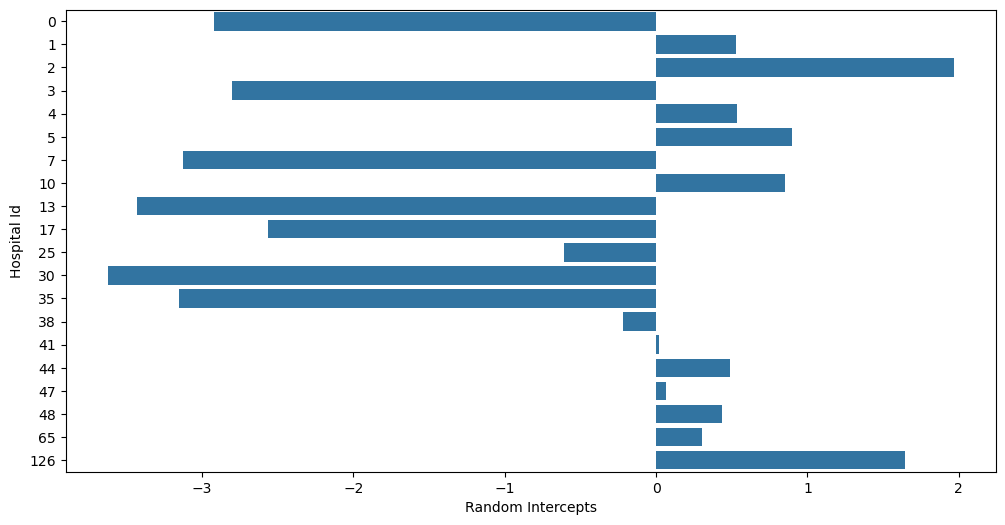

In [ ]:
df_random_effects = training_data_random_effects.reset_index()
df_random_effects.columns = ["hospital_id", "random_intercept"]
df_random_effects = df_random_effects.sort_values(by='hospital_id')
# Set 'hospital_id' as an ordered categorical variable to ensure plot respects this order
df_random_effects["hospital_id"] = pd.Categorical(df_random_effects["hospital_id"], categories=df_random_effects["hospital_id"], ordered=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_random_effects, y='hospital_id', x='random_intercept')
plt.xlabel("Random Intercepts")
plt.ylabel("Hospital Id")
plt.show()

Confusion Matrix:
 [[30 10]
 [ 5 33]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80        40
           1       0.77      0.87      0.81        38

    accuracy                           0.81        78
   macro avg       0.81      0.81      0.81        78
weighted avg       0.81      0.81      0.81        78

AUC: 0.8598684210526317


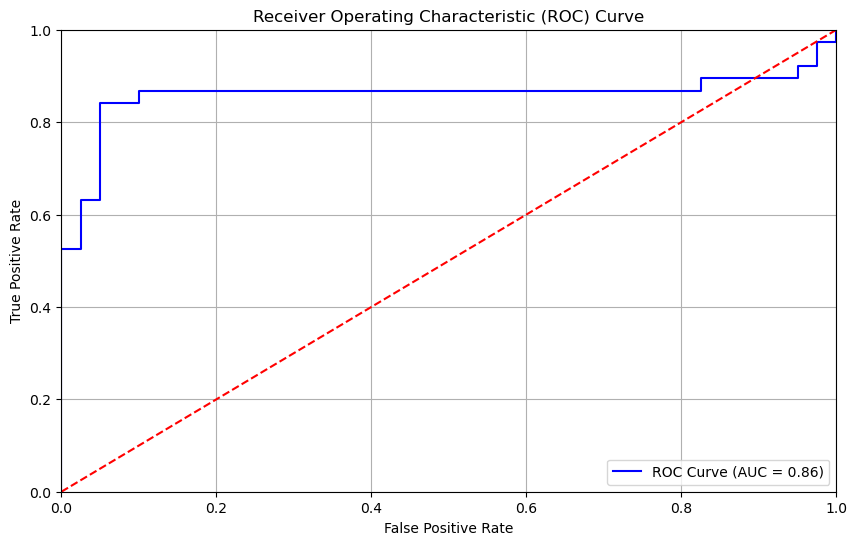

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_proba = glmm_model.predict(X_pred=X_test, group_data_pred=df.loc[test_indexes, 'hospital_id'], predict_response=True)['mu']  # Predict probabilities
y_pred = (y_pred_proba >= 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Compute classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## GLM with hospital as fixed effect

In [ ]:
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()

X_train_1['hospital'] = df.loc[train_indexes, 'hospital_id']
X_test_1['hospital'] = df.loc[test_indexes, 'hospital_id']
X_train_1 = pd.get_dummies(X_train_1, columns=['hospital', 'treatment_type_Radiation', 'treatment_type_Surgery'], drop_first=True, dtype=int)
X_test_1 = pd.get_dummies(X_test_1, columns=['hospital', 'treatment_type_Radiation', 'treatment_type_Surgery'], drop_first=True, dtype=int)

glm_model = sm.Logit(y_train, X_train_1).fit()

print(glm_model.summary())

         Current function value: 0.366291
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:      cancer_recurrence   No. Observations:                  308
Model:                          Logit   Df Residuals:                      283
Method:                           MLE   Df Model:                           24
Date:                Tue, 25 Nov 2025   Pseudo R-squ.:                  0.4696
Time:                        11:50:05   Log-Likelihood:                -112.82
converged:                      False   LL-Null:                       -212.70
Covariance Type:            nonrobust   LLR p-value:                 1.158e-29
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
age                               0.1166      0.185      0.630      0.529      -0.246       0.480
tumor_si

c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


hospital_14
hospital_17
Confusion Matrix:
 [[30 10]
 [11 27]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.75      0.74        40
           1       0.73      0.71      0.72        38

    accuracy                           0.73        78
   macro avg       0.73      0.73      0.73        78
weighted avg       0.73      0.73      0.73        78

AUC: 0.8039473684210526


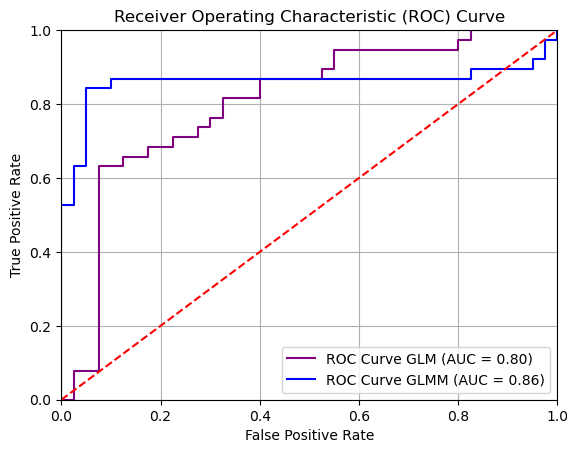

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Remove groups (hospitals) not seen during training
for c in X_test_1.columns:
  if not c in X_train_1.columns:
    print(c)
    X_test_1 = X_test_1.drop(c, axis=1)

for c in X_train_1.columns:
  if not c in X_test_1.columns:
    X_test_1[c] = 0
    print(c)

y_pred_proba = glm_model.predict(X_test_1)  # Predict probabilities
y_pred = (y_pred_proba >= 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Compute classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Compute ROC curve and AUC
fpr_new, tpr_new, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_new = auc(fpr_new, tpr_new)
print(f"AUC: {roc_auc_new}")

# Plot ROC curve
plt.plot(fpr_new, tpr_new, color='purple', label=f'ROC Curve GLM (AUC = {roc_auc_new:.2f})')
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve GLMM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

If you see intersection of the lines we might want to think of which one is better

## GLM without hospitals

In [ ]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()

X_train_2 = pd.get_dummies(X_train_2, columns=['treatment_type_Radiation', 'treatment_type_Surgery'], drop_first=True, dtype=int)
X_test_2 = pd.get_dummies(X_test_2, columns=['treatment_type_Radiation', 'treatment_type_Surgery'], drop_first=True, dtype=int)

glm_model_2 = sm.Logit(y_train, X_train_2).fit()

print(glm_model_2.summary())

Optimization terminated successfully.
         Current function value: 0.662257
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      cancer_recurrence   No. Observations:                  308
Model:                          Logit   Df Residuals:                      302
Method:                           MLE   Df Model:                            5
Date:                Tue, 25 Nov 2025   Pseudo R-squ.:                 0.04103
Time:                        11:56:20   Log-Likelihood:                -203.98
converged:                       True   LL-Null:                       -212.70
Covariance Type:            nonrobust   LLR p-value:                  0.003712
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
age                               0.1761      0.120      1.470      0.

Confusion Matrix:
 [[17 23]
 [ 9 29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.42      0.52        40
           1       0.56      0.76      0.64        38

    accuracy                           0.59        78
   macro avg       0.61      0.59      0.58        78
weighted avg       0.61      0.59      0.58        78

AUC: 0.6664473684210528


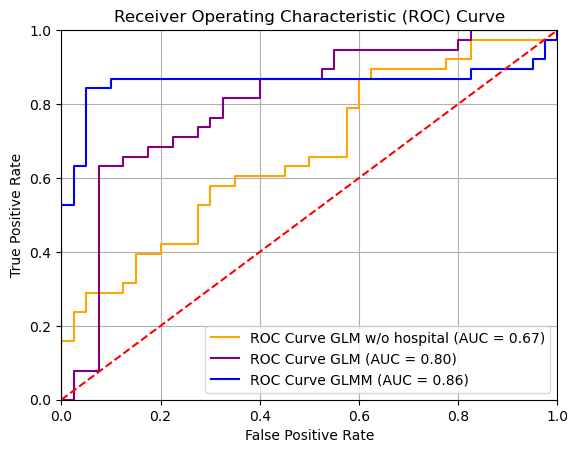

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = glm_model_2.predict(X_test_2)  # Predict probabilities
y_pred = (y_pred_proba >= 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Compute classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Compute ROC curve and AUC
fpr_2, tpr_2, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_2 = auc(fpr_2, tpr_2)
print(f"AUC: {roc_auc_2}")

# Plot ROC curve
plt.plot(fpr_2, tpr_2, color='orange', label=f'ROC Curve GLM w/o hospital (AUC = {roc_auc_2:.2f})')
plt.plot(fpr_new, tpr_new, color='purple', label=f'ROC Curve GLM (AUC = {roc_auc_new:.2f})')
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve GLMM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

The blue one is preferred than the others

## Random Slope

$$
logit(p_{ij}) = \beta_0 + \beta_1 \text{bmi}_{ij} + \beta_2 \text{tumor-size}_{ij} + \ldots + \beta_p \text{X}_{pij} + u_j + v_{j} \cdot \text{FollowUpTime}_{ij} \\
u_j \sim \mathcal{N}(0, \sigma^2_u) \\
v_j \sim \mathcal{N}(0, \sigma^2_v) \\
$$

In [ ]:
# Select relevant predictors for training
vars = ['tumor_size', 'bmi', 'treatment_type_Surgery', 'treatment_type_Radiation', 'follow_up_time']
X_train_2 = X_train[vars]
X_test_2 = X_test[vars]

# Define the grouping variable
groups = df.loc[train_indexes, 'hospital_id']

# Initialize the GPModel with a random slope for follow-up time
gp_model = gpb.GPModel(
    group_data=groups,                        # Grouping variable (hospital_id)
    likelihood="bernoulli_logit",             # Logistic model for binary outcome
    group_rand_coef_data=df.loc[train_indexes, 'follow_up_time'].values,  # Random slope data (follow_up_time)
    ind_effect_group_rand_coef=[1]            # Set to 1 to match the single random effect group
)

# Fit the model
gp_model.fit(y=y_train, X=X_train_2)

# Output the summary of the model
print(gp_model.summary())


Model summary:
Nb. observations: 308
Nb. groups: 20 (hospital_id)
 Log-lik    AIC    BIC
  -70.10 154.20 180.31
-----------------------------------------------------
Covariance parameters (random effects):
                            Param.
hospital_id                   2.22
hospital_id_rand_coef_nb_1    0.31
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                          Param.  Std. err.  z value  P(>|z|)
tumor_size                  0.28        NaN      NaN      NaN
bmi                         0.03       0.28     0.10     0.92
treatment_type_Surgery      0.61       0.53     1.15     0.25
treatment_type_Radiation   -0.79       0.61    -1.31     0.19
follow_up_time              0.06       0.03     1.66     0.10


```hospital_id_rand_coef_nb_1``` is the random slope

Confusion Matrix:
 [[37  3]
 [ 4 34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91        40
           1       0.92      0.89      0.91        38

    accuracy                           0.91        78
   macro avg       0.91      0.91      0.91        78
weighted avg       0.91      0.91      0.91        78

AUC: 0.9427631578947369


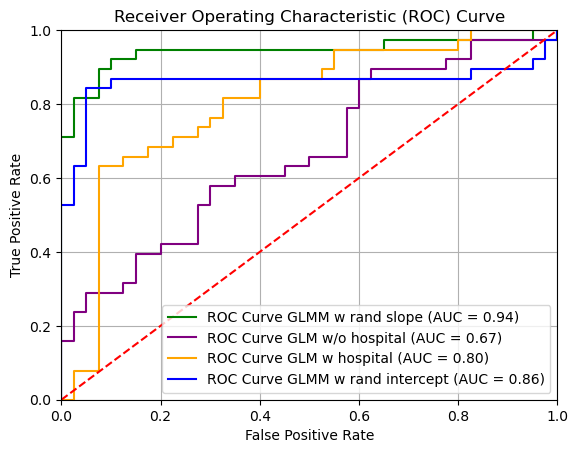

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_proba = gp_model.predict(X_pred=X_test_2, group_data_pred=df.loc[test_indexes, 'hospital_id'], group_rand_coef_data_pred=df.loc[test_indexes, 'follow_up_time'], predict_response=True)['mu']  # Predict probabilities
y_pred = (y_pred_proba >= 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Compute classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Compute ROC curve and AUC
fpr_3, tpr_3, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_3 = auc(fpr_3, tpr_3)
print(f"AUC: {roc_auc_3}")

# Plot ROC curve
plt.plot(fpr_3, tpr_3, color='green', label=f'ROC Curve GLMM w rand slope (AUC = {roc_auc_3:.2f})')
plt.plot(fpr_2, tpr_2, color='purple', label=f'ROC Curve GLM w/o hospital (AUC = {roc_auc_2:.2f})')
plt.plot(fpr_new, tpr_new, color='orange', label=f'ROC Curve GLM w hospital (AUC = {roc_auc_new:.2f})')
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve GLMM w rand intercept (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
all_training_data_random_effects = gp_model.predict_training_data_random_effects()
# The function 'predict_training_data_random_effects' returns predicted random effects for all data points.
# Unique random effects for every group can be obtained as follows
first_occurences = [np.where(groups==i)[0][0] for i in np.unique(groups)]
training_data_random_effects = all_training_data_random_effects.iloc[first_occurences]

In [ ]:
training_data_random_effects.rename(columns={'hospital_id': 'random_intercept', 'hospital_id_rand_coef_nb_1': 'random_slope'})

,random_intercept,random_slope
38,-1.32,0.10
44,-1.71,0.43
1,-1.04,0.34
13,-0.86,-0.42
41,-1.14,0.05
4,-1.63,0.34
48,-1.05,0.14
30,-0.35,-0.39
0,0.23,-0.52
5,-1.59,0.38


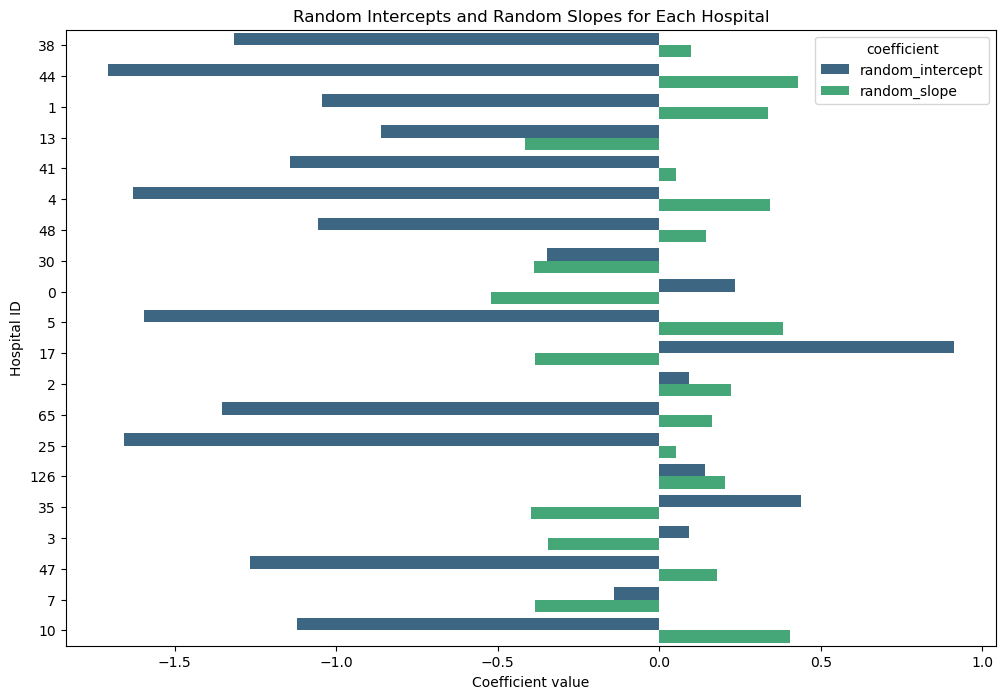

In [ ]:
df_random_effects = training_data_random_effects.reset_index()
df_random_effects.columns = ["hospital_id", "random_intercept", "random_slope"]

# Reshape the DataFrame to a "long" format suitable for showing multiple variables in the same seaborn barplot
df_long = df_random_effects.melt(id_vars=["hospital_id"], value_vars=["random_intercept", "random_slope"],
                                 var_name="coefficient", value_name="value")

# Set 'hospital_id' as a categorical variable to maintain order in the plot
df_long["hospital_id"] = pd.Categorical(df_long["hospital_id"], categories=df_random_effects["hospital_id"], ordered=True)

plt.figure(figsize=(12, 8))

sns.barplot(data=df_long, y="hospital_id", x="value", hue="coefficient", palette="viridis")

plt.ylabel("Hospital ID")
plt.xlabel("Coefficient value")
plt.title("Random Intercepts and Random Slopes for Each Hospital")

plt.show()

## Linear Mixed Model

$$
y_{ij} = \beta_0 + \beta_1 \text{age}_{ij} + \beta_2 \text{bmi}_{ij} + \ldots + \beta_p \text{X}_{pij} + u_j + v_{j} \cdot \text{follow\_up\_time}_{ij} + \epsilon \\
u_j \sim \mathcal{N}(0, \sigma^2_u) \\
v_j \sim \mathcal{N}(0, \sigma^2_v) \\
$$

In [ ]:
import statsmodels.formula.api as smf

# Random intercept for hospital_id and random slope for follow-up time
model = smf.mixedlm("tumor_size ~ age + bmi + follow_up_time",
                     df,
                     groups=df["hospital_id"], # Random intercept
                     re_formula="~ follow_up_time")  # Random slope for follow_up_time
result = model.fit()

print(result.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     tumor_size
No. Observations:     386         Method:                 REML      
No. Groups:           20          Scale:                  4.1009    
Min. group size:      7           Log-Likelihood:         -838.0772 
Max. group size:      30          Converged:              Yes       
Mean group size:      19.3                                          
--------------------------------------------------------------------
                           Coef.  Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                   3.835    0.720 5.323 0.000  2.423  5.247
age                         0.007    0.008 0.933 0.351 -0.008  0.023
bmi                         0.016                                   
follow_up_time              0.004    0.005 0.704 0.482 -0.006  0.013
Group Var                   0.296                 

c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2704: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


Let's consider a model with only follow-up time as predictor + random intercept and slope

In [ ]:
import statsmodels.formula.api as smf

model = smf.mixedlm("tumor_size ~ follow_up_time", # target variable ~ predictors
                     df,
                     groups=df["hospital_id"], # Random intercept
                     re_formula="~ follow_up_time")  # Random slope for follow_up_time
result = model.fit()

print(result.summary())

c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     tumor_size
No. Observations:      386         Method:                 REML      
No. Groups:            20          Scale:                  4.0630    
Min. group size:       7           Log-Likelihood:         -832.6581 
Max. group size:       30          Converged:              No        
Mean group size:       19.3                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   4.735    0.223 21.234 0.000  4.298  5.172
follow_up_time              0.004    0.005  0.652 0.514 -0.007  0.014
Group Var                   0.295    1.726                           
Group x follow_up_time Cov -0.006    0.031                           
follow_up_time Var          0.000   

c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 413.370405
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


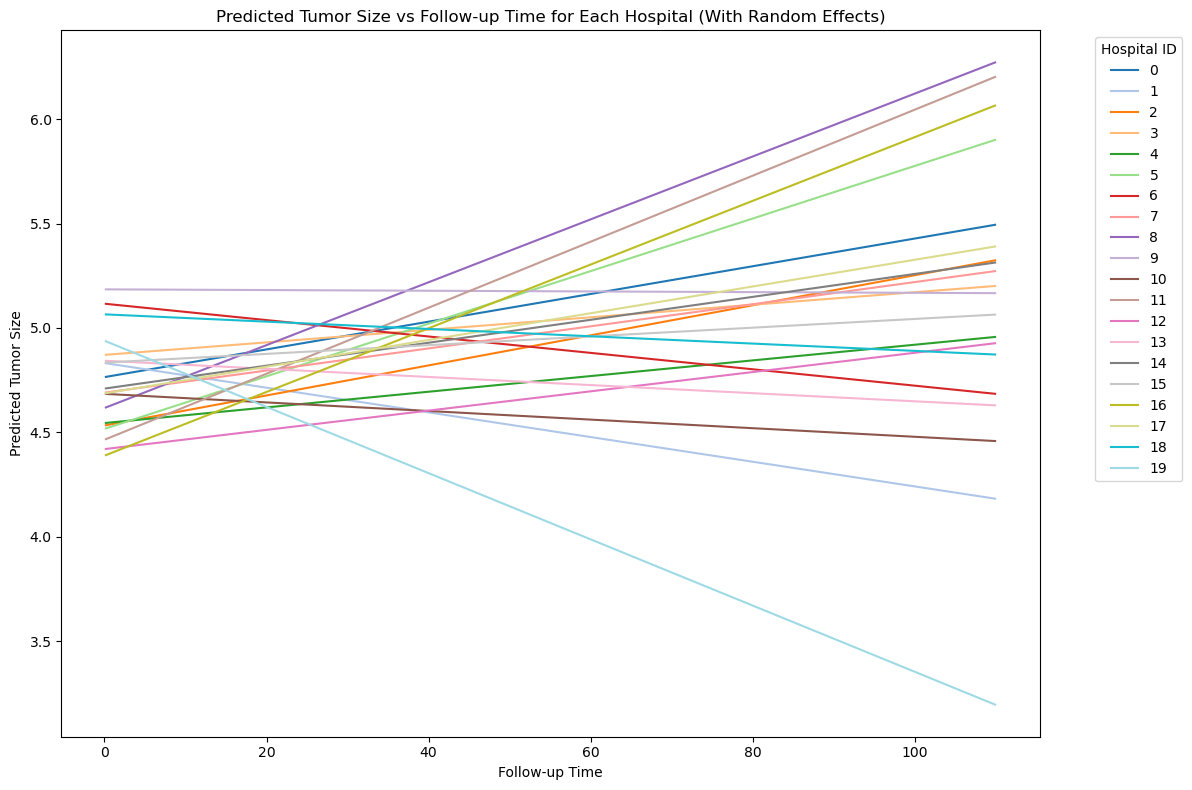

In [ ]:
# Extract fixed effects (intercept and coefficient for follow_up_time)
fixed_effects = result.fe_params
intercept = fixed_effects["Intercept"]
slope = fixed_effects["follow_up_time"]

# Extract random effects (intercept and slope for each hospital_id)
random_effects = result.random_effects

# Generate a sequence of follow_up_time values for plotting
follow_up_time_values = np.linspace(df["follow_up_time"].min(), df["follow_up_time"].max(), 100)

# Prepare a list to store predicted values for each hospital
predicted_lines = []

# Loop over each hospital_id and compute the predicted line
for hospital_id, random_effect in random_effects.items():
    # Get the random intercept and slope for the hospital
    random_intercept = random_effect["Group"]
    random_slope = random_effect["follow_up_time"]

    # Calculate the predicted tumor size for each follow_up_time value
    predicted_tumor_size = intercept + slope * follow_up_time_values + random_intercept + random_slope * follow_up_time_values

    predicted_lines.append(pd.DataFrame({
        "hospital_id": hospital_id,
        "follow_up_time": follow_up_time_values,
        "predicted_tumor_size": predicted_tumor_size
    }))

predicted_df = pd.concat(predicted_lines)

# Plot the predicted lines for each hospital
plt.figure(figsize=(12, 8))
sns.lineplot(data=predicted_df, x="follow_up_time", y="predicted_tumor_size", hue="hospital_id", palette="tab20")

plt.xlabel("Follow-up Time")
plt.ylabel("Predicted Tumor Size")
plt.title("Predicted Tumor Size vs Follow-up Time for Each Hospital (With Random Effects)")
plt.legend(title="Hospital ID", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()